<span style="font-size:3em">How to generate missing values in Python?</span> 

**Aude Sportisse with the help of Marine Le Morvan and Boris Muzellec**

Missing values occur in many domains and most datasets contain missing values (due to non-responses, lost records, machine failures, dataset fusions, etc.). These missing values have to be considered before or during analyses of these datasets.

Now, if you have a method that deals with missing values, for instance imputation or estimation with missing values, how can you assess the performance of your method on a given dataset? If the data already contains missing values, than this does not help you since you generally do not have a ground truth for these missing values. So you will have to simulate missing values, i.e. you remove values – which you therefore know to be the ground truth – to generate missing values.

The mechanisms generating missing values can be various but usually they are classified into three main categories defined by (Rubin 1976): missing completely at random (MCAR), missing at random (MAR) and missing not at random (MNAR). The first two are also qualified as ignorable missing values mechanisms, for instance in likelihood-based approaches to handle missing values, whereas the MNAR mechanism generates nonignorable missing values. In the following we will briefly introduce each mechanism (with the definitions used widely in the literature) and propose ways of simulations missing values under these three mechanism assumptions. For more precise definitions we refer to references in the bibliography on the [R-miss-tastic](https://rmisstastic.netlify.app/bibliography/) website.

# Introduction

## Notations

Let's denote by $\mathbf{X}\in\mathcal{X_1}\times\dots\times\mathcal{X_p}$ the complete observations. We assume that $\mathbf{X}$ is a concatenation of $p$ columns $X_j\in\mathcal{X_j}$, $j\in\{1,\dots,p\}$, where $dim(\mathcal{X_j})=n$ for all $j$. 

The data can be composed of quantitative and/or qualitative values, hence $\mathcal{X_j}$ can be $\mathbb{R}^n$, $\mathbb{Z}^n$ or more generally $\mathcal{S}^n$ for any discrete set $S$.

Missing values are indicated as `NA` (not available) and we define an indicator matrix $\mathbf{R}\in\{0,1\}^{n\times p}$ such that $R_{ij}=1$ if $X_{ij}$ is observed and $R_{ij}=0$ otherwise. We call this matrix $\mathbf{R}$ the response (or missingness) pattern of the observations $\mathbf{X}$. According to this pattern, we can partition the observations $\mathbf{X}$ into observed and missing: $\mathbf{X} = (\mathbf{X}^{obs}, \mathbf{X}^{mis})$.

## Definition of the mechanisms 

In order to define the different missing values mechanisms, both $\mathbf{X}$ and $\mathbf{R}$ are modeled as random variables with probability distributions $\mathbb{P}_X$ and $\mathbb{P}_R$ respectively. We parametrize the missingness distribution $\mathbb{P}_R$ by a parameter $\phi$.

### MCAR 

The observations are said to be Missing Completely At Random (MCAR) if the probability that an observation is missing is independent of the variables and observations: the probability that an observation is missing does not depend on $(\mathbf{X}^{obs},\mathbf{X}^{mis})$. Formally this is:
$$\mathbb{P}_R(R\,|\, X^{obs}, X^{mis}; \phi) = \mathbb{P}_R(R) \qquad \forall \, \phi.$$

### MAR

The observations are said to be Missing At Random (MAR) if the probability that an observation is missing only depends on the observed data $\mathbf{X}^{obs}$. Formally,

$$\mathbb{P}_R(R\,|\,X^{obs},X^{mis};\phi)=\mathbb{P}_R(R\,|\,X^{obs};\phi) \qquad \forall \,\phi,\, \forall \, X^{mis}.$$

### MNAR

The observations are said to be Missing Not At Random (MNAR) in all other cases, i.e. the missingness depends on the missing values and potentially also on the observed values.



# Use of `produce_NA` with default settings

For now, with the main function `produce_NA`, it is possible to generate missing values only for quantitative data which are complete.

Missing values can be generated following one or more of the three main missing values mechanisms (see below for details).

The function is widely based on the code of Boris Muzellec available [here](https://github.com/BorisMuzellec/MissingDataOT).

We generate a small example of observations $\mathbf{X}$:

In [1]:
!pip install wget 

import wget
wget.download('https://raw.githubusercontent.com/BorisMuzellec/MissingDataOT/master/utils.py')

import numpy as np
import pandas as pd
from utils import *
import torch
import seaborn as sns

In [2]:
# Fix the seed ------------------------------------------------------
np.random.seed(0)

In [4]:
# Sample data generation ------------------------------------------------------
# Generate complete data

n = 100
p = 2

mu_X = np.repeat(1, p)
Sigma_X = np.array([[1, 1], [1, 4]])
X_complete_cont = np.random.multivariate_normal(mu_X, Sigma_X, size=n)

from scipy.stats import poisson

lamb = 0.5
X_complete_discr = poisson.rvs(lamb, size=n)
X_complete_discr = np.expand_dims(X_complete_discr, axis=1)


n_cat = 5
X_complete_cat = np.random.binomial(n=n_cat, p=0.5, size=n)
X_complete_cat = np.expand_dims(X_complete_cat, axis=1)

X_complete = np.concatenate((X_complete_cont, X_complete_discr, X_complete_cat),axis=1)

X_complete = pd.DataFrame(X_complete)
X_complete.iloc[:, 3] = X_complete.iloc[:, 3].astype('category')
X_complete.iloc[:, 3].cat.categories = ["F", "E", "D", "C", "B", "A"]
X_complete.head()

,0,1,2,3
0,2.380172,4.405363,1.0,F
1,3.379180,2.400869,0.0,D
2,1.341582,4.944151,0.0,E
3,1.450141,2.922843,0.0,D
4,1.266093,0.695726,2.0,D


## Minimal set of arguments

In order to generate missing values for given data, `produce_NA` requires the following arguments:

* `X`: the initial data (can be only complete for now) as a matrix or data.frame

* `p_miss`: proportion of missing values to generate for variables which will have missing values

* `mecha`: one of "MCAR", "MAR", "MNAR" (default: “MCAR”)

In [5]:
# Function produce_NA for generating missing values ------------------------------------------------------

def produce_NA(X, p_miss, mecha="MCAR", opt=None, p_obs=None, q=None):
    """
    Generate missing values for specifics missing-data mechanism and proportion of missing values. 
    
    Parameters
    ----------
    X : torch.DoubleTensor or np.ndarray, shape (n, d)
        Data for which missing values will be simulated.
        If a numpy array is provided, it will be converted to a pytorch tensor.
    p_miss : float
        Proportion of missing values to generate for variables which will have missing values.
    mecha : str, 
            Indicates the missing-data mechanism to be used. "MCAR" by default, "MAR", "MNAR" or "MNARsmask"
    opt: str, 
         For mecha = "MNAR", it indicates how the missing-data mechanism is generated: using a logistic regression ("logistic"), quantile censorship ("quantile") or logistic regression for generating a self-masked MNAR mechanism ("selfmasked").
    p_obs : float
            If mecha = "MAR", or mecha = "MNAR" with opt = "logistic" or "quanti", proportion of variables with *no* missing values that will be used for the logistic masking model.
    q : float
        If mecha = "MNAR" and opt = "quanti", quantile level at which the cuts should occur.
    
    Returns
    ----------
    A dictionnary containing:
    'X_init': the initial data matrix.
    'X_incomp': the data with the generated missing values.
    'mask': a matrix indexing the generated missing values.s
    """
    
    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = X.astype(np.float32)
        X = torch.from_numpy(X)
    
    if mecha == "MAR":
        mask = MAR_mask(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(X, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(X, p_miss).double()
    else:
        mask = (torch.rand(X.shape) < p_miss).double()
    
    X_nas = X.clone()
    X_nas[mask.bool()] = np.nan
    
    return {'X_init': X.double(), 'X_incomp': X_nas.double(), 'mask': mask}

## Value

`produce_NA` returns a list containing three elements: 

- `X_init`: the initial data
- `X_incomp`: the data with the newly generated missing values
- `mask`: a matrix indexing the generated missing values


## Example

In [6]:
# Minimal example for generating missing data ------------------------
X_miss_mcar = produce_NA(X_complete_cont, p_miss=0.4, mecha="MCAR")

X_mcar = X_miss_mcar['X_incomp']
R_mcar = X_miss_mcar['mask']

print("Percentage of newly generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

Percentage of newly generated missing values:  39.0  %


We can plot the data as a color-encoded matrix, cells with missing values are masked (in white). 

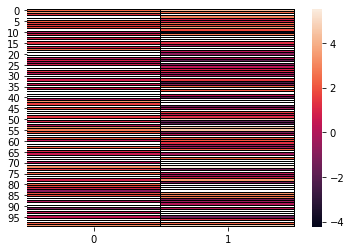

In [7]:
ax = sns.heatmap(X_mcar, mask=R_mcar.numpy()==1, linewidths=0.005, linecolor='black')

# Details on all available specifications

The main function `produce_NA` allows generating missing values in various ways. These can be specified through different arguments: 

`produce_NA(X, p_miss, mecha = "MCAR", opt = None, p_obs = None, q = None)`

## Mechanisms

### MCAR

Missing Completely At Random values are generated using only the desired proportion of missing values `p_miss`, i.e. each value have the same probability `p_miss` of being missing. Therefore, we generate missing values using a Bernoulli distribution of parameter `p_miss`. 

Percentage of generated missing values:  43.5  %


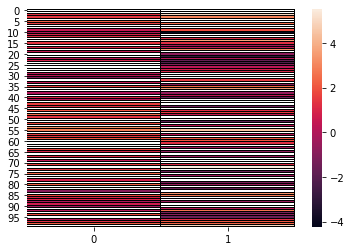

In [8]:
# Sample mcar data -----------------------------------------
X_miss_mcar = produce_NA(X_complete_cont, p_miss=0.4, mecha="MCAR")

X_mcar = X_miss_mcar['X_incomp']
R_mcar = X_miss_mcar['mask']

print("Percentage of generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

ax = sns.heatmap(X_mcar, mask=R_mcar.numpy()==1, linewidths=0.005, linecolor='black')

### MAR

Missing At Random mechanism values are generated by using a logistic model. A subset of fully observed variables (with *no* missing values) is randomly selected. The remaining variables have missing values according to a logistic model (depending on the fully observed variables only) with random weights, re-scaled so as to attain the desired proportion of missing values on those variables.

There is an additional argument: 

* `p_obs`: the proportion of fully observed variables that will be used for the logistic masking model. Note that at least one variable is chosen to be observed

Note that there exists other ways to generate missing values as described in the Rmarkdown [How generate missing values?](https://rmisstastic.netlify.app/how-to/generate/misssimul) by using patterns as in the first definition of Rubin (1976).

Percentage of generated missing values:  21.0  %


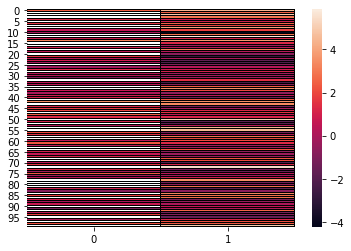

In [9]:
# Sample mar data -----------------------------------------
X_miss_mar = produce_NA(X_complete_cont, p_miss=0.4, mecha="MAR", p_obs=0.5)

X_mar = X_miss_mar['X_incomp']
R_mar = X_miss_mar['mask']

print("Percentage of generated missing values: ", (R_mar.sum()).numpy()/np.prod(R_mar.size())*100, " %")

ax = sns.heatmap(X_mar, mask=R_mar.numpy()==1, linewidths=0.005, linecolor='black')

### MNAR

For generating MNAR data, an aditionnal argument should be given:

* `opt`: it indicates how the missing-data mechanism is generated; using a logistic regression, logistic regression for generating a self-masked MNAR mechanism ("selfmasked") or quantile censorship ("quantile")

#### MNAR with logistic model

With `opt = "logistic"`, missing not at random data are generated with a logistic masking model. It implements two mechanisms:
* Missing probabilities are selected with a logistic model, taking all variables as inputs. Hence, values that are
    inputs can also be missing.
* Variables are split into a set of intputs for a logistic model, and a set whose missing probabilities are
    determined by the logistic model. Then inputs are then masked MCAR (hence, missing values from the second set will depend on masked values).
  
In either case, weights are random and the intercept is selected to attain the desired proportion of missing values.

An additional argument is required: 

* `p_obs`: proportion of variables that will be used for the logistic masking model. Note that at the end, these variables are missing, since they are masked MCAR

Percentage of generated missing values:  39.5  %


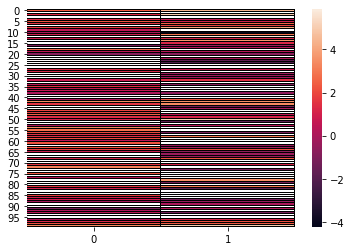

In [9]:
# Sample mnar data with logistic model -----------------------------------------
X_miss_mnar = produce_NA(X_complete_cont, p_miss=0.4, mecha="MNAR", opt="logistic", p_obs=0.5)

X_mnar = X_miss_mnar['X_incomp']
R_mnar = X_miss_mnar['mask']

print("Percentage of generated missing values: ", (R_mnar.sum()).numpy()/np.prod(R_mnar.size())*100, " %")

ax = sns.heatmap(X_mnar, mask=R_mnar.numpy()==1, linewidths=0.005, linecolor='black')

#### Self-masked MNAR

For self-masked MNAR values, the missingness of the variable $X_j$ only depends on the values of $X_j$. 

With `opt = "selfmasked"`, self-masked missing not at random are generated with a logistic self-masking model. 

Variables have missing values probabilities
    given by a logistic model, taking the same variable as input (hence, missingness is independent from one variable
    to another). The intercepts are selected to attain the desired missing rate.

Percentage of generated missing values:  39.0  %


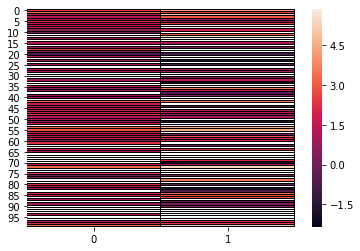

In [10]:
# Sample self-masked mnar data -----------------------------------------
X_miss_selfmasked = produce_NA(X_complete_cont, p_miss=0.4, mecha="MNAR", opt="selfmasked")

X_mnar_selfmasked = X_miss_selfmasked['X_incomp']
R_mnar_selfmasked = X_miss_selfmasked['mask']

print("Percentage of generated missing values: ", (R_mnar_selfmasked.sum()).numpy()/np.prod(R_mnar_selfmasked.size())*100, " %")

ax = sns.heatmap(X_mnar_selfmasked, mask=R_mnar_selfmasked.numpy()==1, linewidths=0.005, linecolor='black')

#### MNAR with quantile censorship

With `opt = "quantile"`, missing not at random data are generated by using quantile censorship. First, a subset of variables which will have missing variables is randomly selected. Then, missing values are generated on the q-quantiles at random. Since missingness depends on quantile information, it depends on masked values, hence this is a MNAR mechanism.
    
Two additional arguments are required: 

* `p_obs`: the proportion of fully observed variables. Note that at least one variable is chosen to be observed. 

* `q`: quantile level at which the cuts should occur.

Percentage of generated missing values:  16.5  %


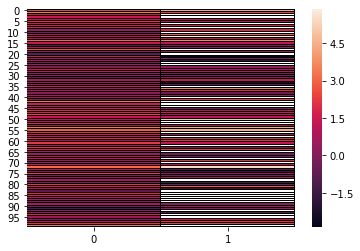

In [11]:
# Sample mnar missing data with quantiles -----------------------------------------
X_miss_quant = produce_NA(X_complete_cont, p_miss=0.4, mecha="MNAR", opt="quantile", p_obs=0.5, q=0.3)

X_mnar_quant = X_miss_quant['X_incomp']
R_mnar_quant = X_miss_quant['mask']

print("Percentage of generated missing values: ", (R_mnar_quant.sum()).numpy()/np.prod(R_mnar_quant.size())*100, " %")

ax = sns.heatmap(X_mnar_quant, mask=R_mnar_quant.numpy()==1, linewidths=0.005, linecolor='black')